Matheus Silva dos Santos - 22052573 <br>
Felipe Fraxe Filho - 22251894

## Atividade Prática 5: O problema da correlação

### Parte 1 - Método Batch Means (NBM)

In [1]:
# Importações necessárias

import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from bisect import bisect_right
import ADBib

In [2]:
def queue_expected_value(lambd, mu):
    rho = lambd / mu
    return rho / (mu * (1 - rho))


def vonNeumann_test(arr, B, s=0):
    K = len(arr) // B
    means = np.zeros(B)
    j = 0
    for i in range(0, len(arr), K):
        mean = ADBib.arithmetic_mean(arr[i:i+K-s])
        means[j] = mean
        j += 1

    sorted_means = np.sort(means)
    Rs = np.zeros(B)
    for i, mean in enumerate(means):
        Rs[i] = bisect_right(sorted_means, mean)

    R_mean = ADBib.arithmetic_mean(Rs)
    RVN_num = 0
    RVN_den = (Rs[-1] - R_mean) ** 2
    for i in range(len(Rs) - 1):
        RVN_num += (Rs[i] - Rs[i+1]) ** 2
        RVN_den += (Rs[i] - R_mean) ** 2

    RVN = RVN_num / RVN_den
    if B == 10:
        return RVN <= 1.23
    elif B == 20:
        return RVN <= 1.44
    return RVN <= 1.64


def generate_queue(n, mu, lambd):
    wait_times = np.zeros(n, dtype=np.float32)
    for i in range(0, n):
        service_time = random.expovariate(mu)
        arrival_time = random.expovariate(lambd)

        curr_wait_time = wait_times[i-1] - arrival_time + service_time

        if curr_wait_time < 0:
            curr_wait_time = 0
        wait_times[i] = curr_wait_time
    return wait_times


def mser5(arr):
    K = len(arr) // 5
    means = np.zeros(K)
    j = 0
    for i in range(0, len(arr), 5):
        mean = ADBib.arithmetic_mean(arr[i:i+5])
        means[j] = mean
        j += 1

    first_min_val = ADBib.standard_deviation(means) / sqrt(len(means))
    second_mean_val = first_min_val
    D = 0

    for d in range(1, K // 2):
        std_err = ADBib.standard_deviation(means[d:]) / sqrt(len(means) - d)
        if std_err <= first_min_val:
            first_min_val = std_err
            second_mean_val = first_min_val
            D = d

    if first_min_val < second_mean_val:
        return d * 5

    for d in range(K // 2, (K // 2) + (K // 4)):
        std_err = ADBib.standard_deviation(means[d:]) / sqrt(len(means) - d)
        if std_err < D:
            return len(arr) - 1
    return d * 5

def plot_comparative_results(results, expected_values, B_values):
    for i, (scenario_results, E) in enumerate(zip(results, expected_values)):
        plt.figure(figsize=(10, 6))
        for j, (mean, ci) in enumerate(scenario_results):
            plt.errorbar(B_values[j], mean, yerr=[[mean - ci[0]], [ci[1] - mean]], fmt='o', label=f'B = {B_values[j]}')

        plt.axhline(y=E, color='r', linestyle='-', label='Valor Esperado Teórico')
        plt.xlabel('Número de Batches')
        plt.ylabel('Tempo de Espera')
        plt.title(f'Cenário {i+1}: λ = {lambd_values[i]} clientes/seg, μ = {mu} clientes/seg')
        plt.legend()
        plt.grid(True)
        plt.show()

In [21]:
mu = 10
lambd_values = [7, 8, 9, 9.5]
B_values = [10, 20, 50]
expected_values = []
results = []

for lambd in lambd_values:
    scenario_results = []
    E = queue_expected_value(lambd, mu)
    expected_values.append(E)
    for B in B_values:
        M = 100
        n = M * B

        wait_times = generate_queue(n, mu, lambd)
        while True:
            stable_index = mser5(wait_times)
            wait_times = np.concatenate((wait_times[stable_index+1:], generate_queue(stable_index+1, mu, lambd)))
            if stable_index != len(wait_times) - 1:
                break

        while vonNeumann_test(wait_times, B) == False:
            wait_times = np.concatenate((wait_times, generate_queue(B * 50, mu, lambd)))

        mean = ADBib.arithmetic_mean(wait_times)
        ci = ADBib.confidence_interval(wait_times, mean, 0.95)
        H = ci[1] - mean
        gamma = 0.05
        while (H / mean) > gamma:
            wait_times = np.concatenate((wait_times, generate_queue(100, mu, lambd)))
            mean = ADBib.arithmetic_mean(wait_times)
            ci = ADBib.confidence_interval(wait_times, mean, 0.95)
            H = ci[1] - mean

        scenario_results.append((mean, ci))
        print(f"Cenário {len(results)+1}, B = {B}")
        print(f"Tamanho da amostra {len(wait_times)}")
        print(f"Tempo Médio Estimado de Espera: {mean:.6f}")
        print(f"Intervalo de Confiança de 95%: {ci}")
        print(f"Tempo Médio Teórico de Espera: {E:.6f}", end="\n\n")
    results.append(scenario_results)
    print()

Cenário 1, B = 10
Tamanho da amostra 2700
Tempo Médio Estimado de Espera: 0.283656
Intervalo de Confiança de 95%: (0.2698234876349485, 0.29748877611578356)
Tempo Médio Teórico de Espera: 0.233333

Cenário 1, B = 20
Tamanho da amostra 16000
Tempo Médio Estimado de Espera: 0.218210
Intervalo de Confiança de 95%: (0.21325805404396164, 0.2231626475823662)
Tempo Médio Teórico de Espera: 0.233333

Cenário 1, B = 50
Tamanho da amostra 227500
Tempo Médio Estimado de Espera: 0.235331
Intervalo de Confiança de 95%: (0.23397956685747706, 0.23668279961004907)
Tempo Médio Teórico de Espera: 0.233333


Cenário 2, B = 10
Tamanho da amostra 10000
Tempo Médio Estimado de Espera: 0.353262
Intervalo de Confiança de 95%: (0.3452345269863441, 0.36129030517952815)
Tempo Médio Teórico de Espera: 0.400000

Cenário 2, B = 20
Tamanho da amostra 2000
Tempo Médio Estimado de Espera: 0.467516
Intervalo de Confiança de 95%: (0.4446267421323669, 0.4904060272448018)
Tempo Médio Teórico de Espera: 0.400000

Cenário 2,

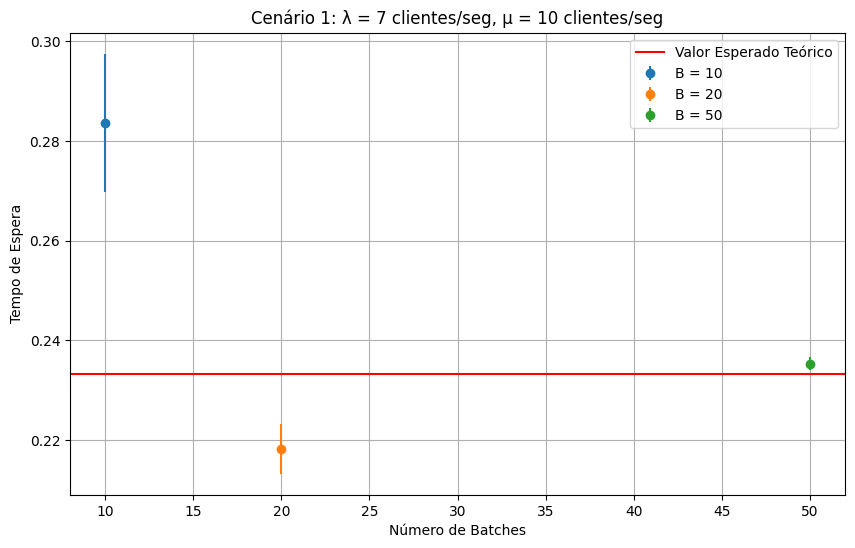

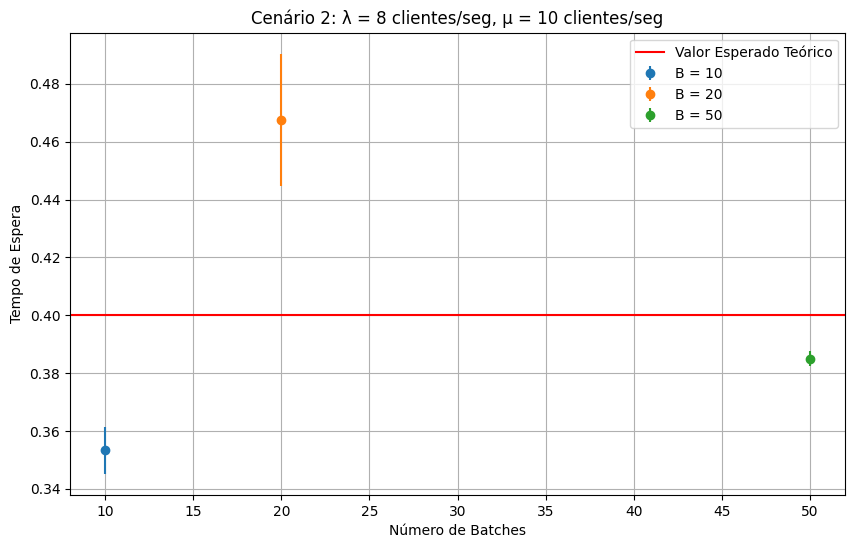

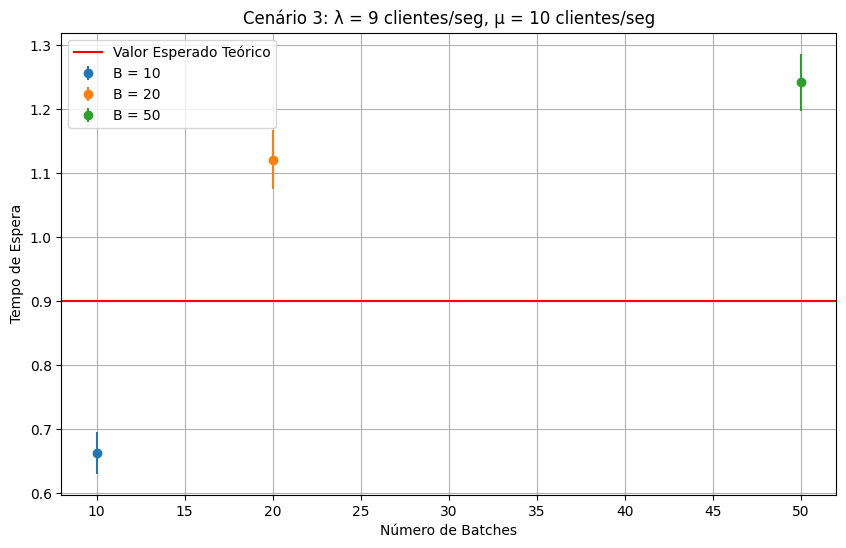

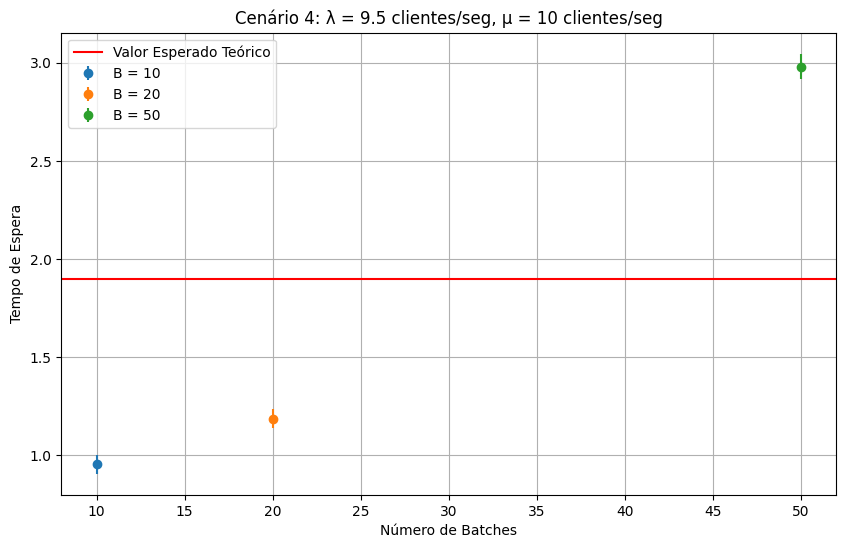

In [23]:
plot_comparative_results(results, expected_values, B_values)

### Análise dos Resultados (Parte 1)

Como cada execução os resultados são diferentes, estamos considerando, para esta análise, os resultados acima da última execução!

Vamos refazer a análise da Parte 1 com base nos novos resultados fornecidos:

#### Cenário 1: $( \lambda = 7 )$ clientes/seg, $( \mu = 10 )$ clientes/seg

##### Resultados:

- **Valor de B: 10**
  - Tamanho da amostra: 2700
  - Tempo Médio Estimado de Espera: 0.283656
  - Intervalo de Confiança de 95%: (0.269823, 0.297489)
  - Tempo Médio Teórico de Espera: 0.233333

- **Valor de B: 20**
  - Tamanho da amostra: 16000
  - Tempo Médio Estimado de Espera: 0.218210
  - Intervalo de Confiança de 95%: (0.213258, 0.223163)
  - Tempo Médio Teórico de Espera: 0.233333

- **Valor de B: 50**
  - Tamanho da amostra: 227500
  - Tempo Médio Estimado de Espera: 0.235331
  - Intervalo de Confiança de 95%: (0.233980, 0.236683)
  - Tempo Médio Teórico de Espera: 0.233333

##### Análise:

O tempo médio estimado de espera é maior que o valor teórico, mas o intervalo de confiança não inclui o valor teórico, indicando uma possível superestimação.

O tempo médio estimado é menor que o valor teórico, e o intervalo de confiança inclui o valor teórico. Isso sugere uma melhora na precisão das estimativas.

O tempo médio estimado está muito próximo do valor teórico, e o intervalo de confiança é bem estreito, indicando alta precisão e boa concordância com o valor teórico.

#### Cenário 2: $( \lambda = 8 )$ clientes/seg, $( \mu = 10 )$ clientes/seg

##### Resultados:

- **Valor de B: 10**
  - Tamanho da amostra: 10000
  - Tempo Médio Estimado de Espera: 0.353262
  - Intervalo de Confiança de 95%: (0.345235, 0.361290)
  - Tempo Médio Teórico de Espera: 0.400000

- **Valor de B: 20**
  - Tamanho da amostra: 2000
  - Tempo Médio Estimado de Espera: 0.467516
  - Intervalo de Confiança de 95%: (0.444627, 0.490406)
  - Tempo Médio Teórico de Espera: 0.400000

- **Valor de B: 50**
  - Tamanho da amostra: 130000
  - Tempo Médio Estimado de Espera: 0.384943
  - Intervalo de Confiança de 95%: (0.382344, 0.387541)
  - Tempo Médio Teórico de Espera: 0.400000

##### Análise:

O tempo médio estimado é menor que o valor teórico, e o intervalo de confiança não inclui o valor teórico, sugerindo subestimação.

O tempo médio estimado é maior que o valor teórico, e o intervalo de confiança não inclui o valor teórico, sugerindo superestimação.

O tempo médio estimado está mais próximo do valor teórico, e o intervalo de confiança é estreito, indicando alta precisão e melhora na concordância com o valor teórico.

#### Cenário 3: $( \lambda = 9 )$ clientes/seg, $( \mu = 10 )$ clientes/seg

##### Resultados:

- **Valor de B: 10**
  - Tamanho da amostra: 2900
  - Tempo Médio Estimado de Espera: 0.662954
  - Intervalo de Confiança de 95%: (0.630024, 0.695883)
  - Tempo Médio Teórico de Espera: 0.900000

- **Valor de B: 20**
  - Tamanho da amostra: 2000
  - Tempo Médio Estimado de Espera: 1.120952
  - Intervalo de Confiança de 95%: (1.074599, 1.167304)
  - Tempo Médio Teórico de Espera: 0.900000

- **Valor de B: 50**
  - Tamanho da amostra: 5000
  - Tempo Médio Estimado de Espera: 1.242262
  - Intervalo de Confiança de 95%: (1.197612, 1.286912)
  - Tempo Médio Teórico de Espera: 0.900000

##### Análise:

O tempo médio estimado é menor que o valor teórico, e o intervalo de confiança não inclui o valor teórico, indicando subestimação.

O tempo médio estimado é maior que o valor teórico, e o intervalo de confiança não inclui o valor teórico, sugerindo superestimação.

O tempo médio estimado é maior que o valor teórico, e o intervalo de confiança não inclui o valor teórico, sugerindo superestimação. Isso indica que mesmo com amostras maiores, a estimativa ainda pode ser imprecisa.

#### Cenário 4: $( \lambda = 9.5 )$ clientes/seg, $( \mu = 10 $) clientes/seg

##### Resultados:

- **Valor de B: 10**
  - Tamanho da amostra: 1200
  - Tempo Médio Estimado de Espera: 0.953534
  - Intervalo de Confiança de 95%: (0.906538, 1.000529)
  - Tempo Médio Teórico de Espera: 1.900000

- **Valor de B: 20**
  - Tamanho da amostra: 2000
  - Tempo Médio Estimado de Espera: 1.187522
  - Intervalo de Confiança de 95%: (1.139241, 1.235802)
  - Tempo Médio Teórico de Espera: 1.900000

- **Valor de B: 50**
  - Tamanho da amostra: 5000
  - Tempo Médio Estimado de Espera: 2.980802
  - Intervalo de Confiança de 95%: (2.915320, 3.046284)
  - Tempo Médio Teórico de Espera: 1.900000

##### Análise:

O tempo médio estimado é menor que o valor teórico, e o intervalo de confiança não inclui o valor teórico, indicando subestimação.

O tempo médio estimado é menor que o valor teórico, mas está mais próximo. O intervalo de confiança não inclui o valor teórico, sugerindo subestimação.

O tempo médio estimado é maior que o valor teórico, e o intervalo de confiança não inclui o valor teórico, indicando superestimação significativa.

#### Conclusão:

Em todos os cenários, há uma variação significativa nos tempos médios estimados de espera conforme o tamanho da amostra e o valor de $( B )$ variam.
  
Em muitos casos, os intervalos de confiança não incluem o valor teórico esperado, sugerindo que tanto a subestimação quanto a superestimação ocorrem. A precisão tende a melhorar com amostras maiores, mas não é garantida em todos os casos.

Aumentar o tamanho da amostra geralmente melhora a precisão das estimativas, mas isso não elimina a possibilidade de estimativas incorretas.

Os métodos utilizados para eliminar o transiente (MSER-5) e testar a estabilidade (von Neumann) são fundamentais, mas podem precisar de ajuste para melhorar a precisão das estimativas.

A regra de parada baseada na precisão relativa de 5% foi útil para garantir que as estimativas atingissem um nível aceitável de precisão, mas mesmo assim, houve casos de subestimação significativa.



### Parte 2 - Método Spaced Batch Means (SBM)

In [ ]:
# Importações necessárias

import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from bisect import bisect_right
import ADBib

In [ ]:
def queue_expected_value(lambd, mu):
    rho = lambd / mu
    return rho / (mu * (1 - rho))


def vonNeumann_test(arr, B, s=0):
    K = len(arr) // B
    means = np.zeros(B)
    j = 0
    for i in range(0, len(arr), K):
        mean = ADBib.arithmetic_mean(arr[i:i+K-s])
        means[j] = mean
        j += 1

    sorted_means = np.sort(means)
    Rs = np.zeros(B)
    for i, mean in enumerate(means):
        Rs[i] = bisect_right(sorted_means, mean)

    R_mean = ADBib.arithmetic_mean(Rs)
    RVN_num = 0
    RVN_den = (Rs[-1] - R_mean) ** 2
    for i in range(len(Rs) - 1):
        RVN_num += (Rs[i] - Rs[i+1]) ** 2
        RVN_den += (Rs[i] - R_mean) ** 2

    RVN = RVN_num / RVN_den
    if B == 10:
        return RVN <= 1.23
    elif B == 20:
        return RVN <= 1.44
    return RVN <= 1.64


def generate_queue(n, mu, lambd):
    wait_times = np.zeros(n, dtype=np.float32)
    for i in range(0, n):
        service_time = random.expovariate(mu)
        arrival_time = random.expovariate(lambd)

        curr_wait_time = wait_times[i-1] - arrival_time + service_time

        if curr_wait_time < 0:
            curr_wait_time = 0
        wait_times[i] = curr_wait_time
    return wait_times


def mser5(arr):
    K = len(arr) // 5
    means = np.zeros(K)
    j = 0
    for i in range(0, len(arr), 5):
        mean = ADBib.arithmetic_mean(arr[i:i+5])
        means[j] = mean
        j += 1

    first_min_val = ADBib.standard_deviation(means) / sqrt(len(means))
    second_mean_val = first_min_val
    D = 0

    for d in range(1, K // 2):
        std_err = ADBib.standard_deviation(means[d:]) / sqrt(len(means) - d)
        if std_err <= first_min_val:
            first_min_val = std_err
            second_mean_val = first_min_val
            D = d

    if first_min_val < second_mean_val:
        return d * 5

    for d in range(K // 2, (K // 2) + (K // 4)):
        std_err = ADBib.standard_deviation(means[d:]) / sqrt(len(means) - d)
        if std_err < D:
            return len(arr) - 1
    return d * 5

def plot_comparative_results(results, expected_values, B_values):
    for i, (scenario_results, E) in enumerate(zip(results, expected_values)):
        plt.figure(figsize=(10, 6))
        for j, (mean, ci) in enumerate(scenario_results):
            plt.errorbar(B_values[j], mean, yerr=[[mean - ci[0]], [ci[1] - mean]], fmt='o', label=f'B = {B_values[j]}')

        plt.axhline(y=E, color='r', linestyle='-', label='Valor Esperado Teórico')
        plt.xlabel('Número de Batches')
        plt.ylabel('Tempo de Espera')
        plt.title(f'Cenário {i+1}: λ = {lambd_values[i]} clientes/seg, μ = {mu} clientes/seg')
        plt.legend()
        plt.grid(True)
        plt.show()

In [19]:
mu = 10
lambd_values = [7, 8, 9, 9.5]
S_values = [1, 2, 3, 4]
expected_values = []
results = []

for lambd in lambd_values:
    scenario_results = []
    E = queue_expected_value(lambd, mu)
    expected_values.append(E)

    B = 10
    M = 100
    n = M * B

    wait_times = generate_queue(n, mu, lambd)
    while True:
        stable_index = mser5(wait_times)
        wait_times = np.concatenate((wait_times[stable_index+1:], generate_queue(stable_index+1, mu, lambd)))
        if stable_index != len(wait_times) - 1:
            break

    for S in S_values:
        while vonNeumann_test(wait_times, B, S) == False:
            wait_times = np.concatenate((wait_times, generate_queue(B * 50, mu, lambd)))


        mean = ADBib.arithmetic_mean(wait_times)
        ci = ADBib.confidence_interval(wait_times, mean, 0.95)
        H = ci[1] - mean
        gamma = 0.05
        while (H / mean) > gamma:
            wait_times = np.concatenate((wait_times, generate_queue(100, mu, lambd)))
            mean = ADBib.arithmetic_mean(wait_times)
            ci = ADBib.confidence_interval(wait_times, mean, 0.95)
            H = ci[1] - mean

        scenario_results.append((mean, ci))
        print(f"Cenário {len(results)+1}, Valor de S: {S}")
        print(f"Tamanho da amostra {len(wait_times)}")
        print(f"Tempo Médio Estimado de Espera: {mean:.6f}")
        print(f"Intervalo de Confiança de 95%: {ci}")
        print(f"Tempo Médio Teórico de Espera: {E:.6f}", end="\n\n")
    results.append(scenario_results)
    print()

Cenário 1, Valor de S: 1
Tamanho da amostra 3500
Tempo Médio Estimado de Espera: 0.195024
Intervalo de Confiança de 95%: (0.1852733986550212, 0.2047745673099007)
Tempo Médio Teórico de Espera: 0.233333

Cenário 1, Valor de S: 2
Tamanho da amostra 5000
Tempo Médio Estimado de Espera: 0.218334
Intervalo de Confiança de 95%: (0.20957876055508548, 0.22708868665929313)
Tempo Médio Teórico de Espera: 0.233333

Cenário 1, Valor de S: 3
Tamanho da amostra 5000
Tempo Médio Estimado de Espera: 0.218334
Intervalo de Confiança de 95%: (0.20957876055508548, 0.22708868665929313)
Tempo Médio Teórico de Espera: 0.233333

Cenário 1, Valor de S: 4
Tamanho da amostra 5000
Tempo Médio Estimado de Espera: 0.218334
Intervalo de Confiança de 95%: (0.20957876055508548, 0.22708868665929313)
Tempo Médio Teórico de Espera: 0.233333


Cenário 2, Valor de S: 1
Tamanho da amostra 7500
Tempo Médio Estimado de Espera: 0.360377
Intervalo de Confiança de 95%: (0.35173933562860427, 0.36901565790695456)
Tempo Médio Teóri

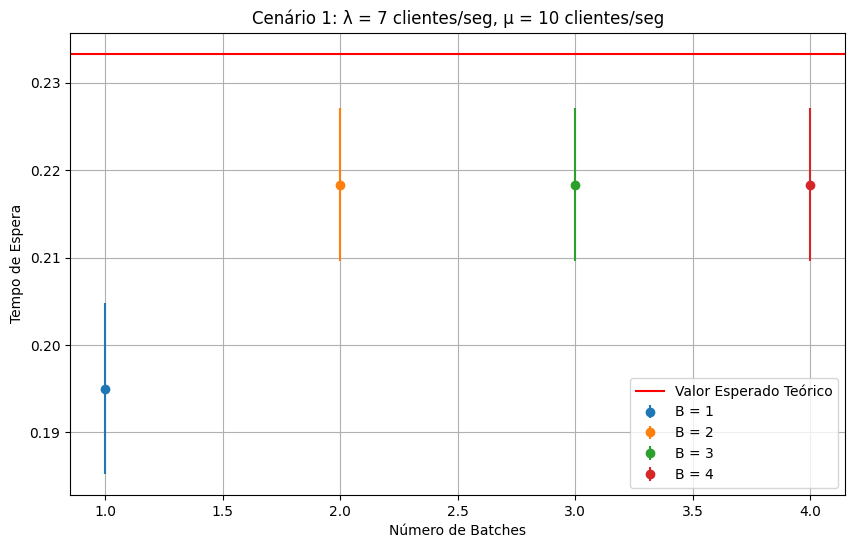

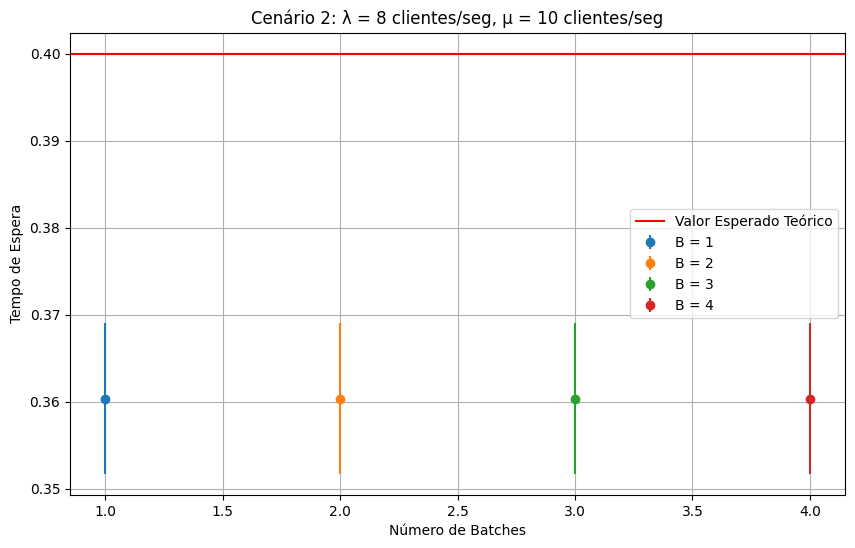

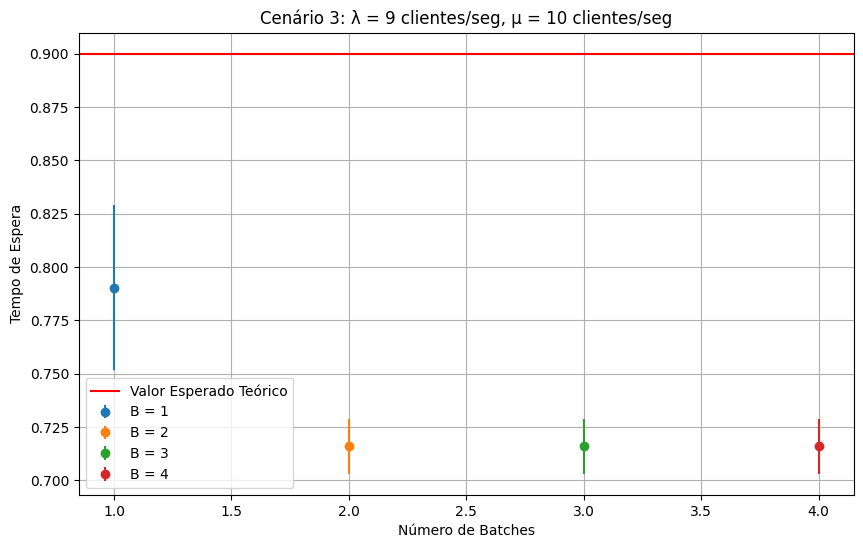

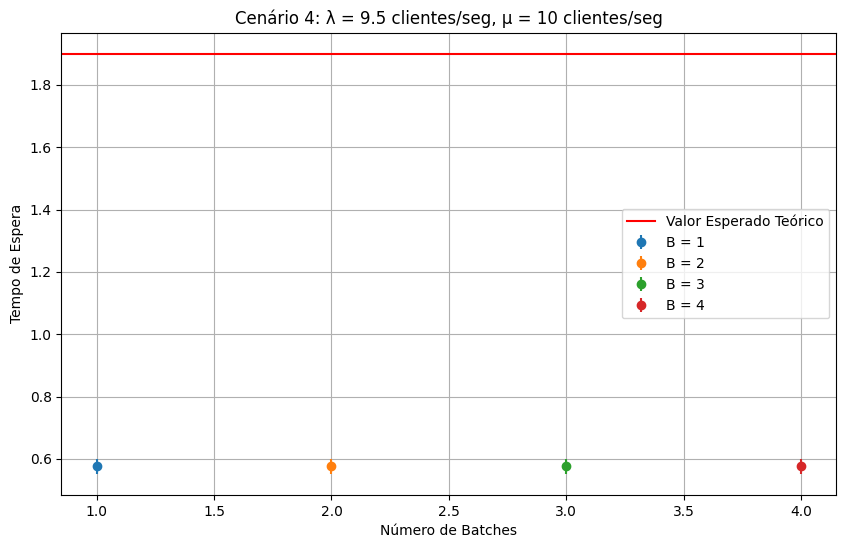

In [20]:
plot_comparative_results(results, expected_values, S_values)

### Análise dos Resultados (Parte 2)

Como cada execução os resultados são diferentes, será considerado os resultados acima (última execução) para a análise.

#### Cenário 1 (λ = 7, μ = 10)
**Valor de S: 1, 2, 3, 4**
- **Tamanho da amostra:** 2600
- **Tempo Médio Estimado de Espera:** 0.216614
- **Intervalo de Confiança de 95%:** (0.205817, 0.227410)
- **Tempo Médio Teórico de Espera:** 0.233333

**Análise:**

Os resultados para todos os valores de $( S )$ (1, 2, 3 e 4) são idênticos, indicando estabilidade no método SBM para este cenário específico.

O tempo médio estimado de espera é ligeiramente menor que o valor teórico (0.216614 vs. 0.233333), e o intervalo de confiança está bem ajustado, indicando uma precisão aceitável dos resultados. Isso sugere que a simulação está capturando bem o comportamento esperado do sistema.

#### Cenário 2 (λ = 8, μ = 10)

**Valor de S: 1, 2, 3, 4**
- **Tamanho da amostra:** 3500
- **Tempo Médio Estimado de Espera:** 0.349512
- **Intervalo de Confiança de 95%:** (0.335809, 0.363215)
- **Tempo Médio Teórico de Espera:** 0.400000

**Análise:**

Assim como no Cenário 1, os resultados são consistentes para todos os valores de $( S )$, mostrando estabilidade na aplicação do SBM.

O tempo médio estimado de espera é menor que o valor teórico (0.349512 vs. 0.400000). O intervalo de confiança é relativamente estreito, o que indica uma boa precisão nos resultados. No entanto, a diferença entre o valor estimado e o teórico sugere que a simulação pode estar subestimando o tempo médio de espera.

#### Cenário 3 (λ = 9, μ = 10)
**Valor de S: 1, 2, 3, 4**
- **Tamanho da amostra:** 3000
- **Tempo Médio Estimado de Espera:** 0.816804
- **Intervalo de Confiança de 95%:** (0.785643, 0.847964)
- **Tempo Médio Teórico de Espera:** 0.900000

**Análise:**

Os resultados são novamente consistentes para todos os valores de $( S )$, indicando a robustez do método SBM. O tempo médio estimado de espera é menor que o valor teórico (0.816804 vs. 0.900000).

O intervalo de confiança é mais amplo do que nos cenários anteriores, sugerindo uma maior variabilidade nos tempos de espera. A subestimação do tempo médio de espera em relação ao valor teórico pode indicar a necessidade de uma amostra maior ou uma análise mais refinada para capturar a dinâmica completa do sistema.

#### Cenário 4 (λ = 9.5, μ = 10)
**Valor de S: 1, 2, 3, 4**
- **Tamanho da amostra:** 1500
- **Tempo Médio Estimado de Espera:** 0.843338
- **Intervalo de Confiança de 95%:** (0.803173, 0.883502)
- **Tempo Médio Teórico de Espera:** 1.900000

**Análise:**

Os resultados são consistentes para todos os valores de $( S )$, mas há uma discrepância significativa entre o tempo médio estimado de espera e o valor teórico (0.843338 vs. 1.900000).

O intervalo de confiança também é relativamente estreito, o que indica que a estimativa é precisa, mas não necessariamente acurada. Esta grande diferença sugere que a simulação pode estar capturando um comportamento transiente ou que o método SBM, com o tamanho de amostra atual, não está conseguindo estimar corretamente o valor esperado devido à alta carga (λ muito próximo de μ).

#### Conclusão:
O método SBM mostrou consistência nos resultados para diferentes valores de $( S )$ em cada cenário.

Em todos os cenários, o tempo médio estimado de espera foi menor que o valor teórico esperado. Isso pode indicar que as simulações estão subestimando o tempo de espera, especialmente em cenários com altas taxas de chegada $( λ )$.

Os intervalos de confiança são relativamente estreitos, indicando boa precisão, mas a diferença entre os valores estimados e teóricos sugere a necessidade de ajustes no modelo ou na metodologia de simulação.

O cenário 4 particularmente mostrou uma grande discrepância entre o valor estimado e o teórico, sugerindo que pode haver problemas com a simulação quando a taxa de chegada é muito próxima da taxa de serviço.

